In [1]:
import pandas as pd
import numpy as np
import urllib.request, json
import matplotlib
import matplotlib.pyplot as plt
import unicodedata
import folium
from folium.plugins import TimeSliderChoropleth
import geopandas as gp
from datetime import datetime
from colour import Color

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto19/CasosActivosPorComuna.csv",header=0)
df.head()

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-04-13,2020-04-15,2020-04-17,2020-04-20,2020-04-24,...,2020-06-08,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13
0,Arica y Parinacota,15,Arica,15101.0,247552.0,88.0,80.0,72.0,65.0,77.0,...,278.0,328.0,353.0,358.0,381.0,408.0,406.0,495.0,575.0,655.0
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,8.0,7.0,1.0,1.0,1.0,15.0,17.0
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [3]:
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    s = s.replace(" ", "_")
    return s

In [4]:
df['Comuna_Clean'] = df['Comuna'].apply(lambda x: elimina_tildes(x))

In [14]:
#df_metro = df[df['Region'] == 'Metropolitana'].copy()
df_metro = df.copy()
df_metro.drop(columns={'Codigo region'}, inplace=True)
df_metro.head()

,Region,Comuna,Codigo comuna,Poblacion,2020-04-13,2020-04-15,2020-04-17,2020-04-20,2020-04-24,2020-04-27,...,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13,Comuna_Clean
0,Arica y Parinacota,Arica,15101.0,247552.0,88.0,80.0,72.0,65.0,77.0,103.0,...,328.0,353.0,358.0,381.0,408.0,406.0,495.0,575.0,655.0,Arica
1,Arica y Parinacota,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Camarones
2,Arica y Parinacota,General Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,General_Lagos
3,Arica y Parinacota,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,8.0,7.0,1.0,1.0,1.0,15.0,17.0,Putre
4,Arica y Parinacota,Desconocido Arica y Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,Desconocido_Arica_y_Parinacota


In [6]:
df_id_comunas = df_metro[['Comuna_Clean', 'Codigo comuna']].copy()
df_id_comunas.dropna(inplace=True)
df_id_comunas['Codigo comuna'] = df_id_comunas['Codigo comuna'].astype(int)
df_id_comunas.head()

,Comuna_Clean,Codigo comuna
0,Arica,15101
1,Camarones,15102
2,General_Lagos,15202
3,Putre,15201
6,Alto_Hospicio,1107


In [15]:
#Viva le función melt, viva... Sirve para "Despivotear" DataFrames
unpivoted = df_metro.melt(id_vars=['Comuna', 'Comuna_Clean' ,'Codigo comuna', 'Poblacion', 'Region'], var_name='fecha', value_name='Casos Activos')
unpivoted.head()

,Comuna,Comuna_Clean,Codigo comuna,Poblacion,Region,fecha,Casos Activos
0,Arica,Arica,15101.0,247552.0,Arica y Parinacota,2020-04-13,88.0
1,Camarones,Camarones,15102.0,1233.0,Arica y Parinacota,2020-04-13,0.0
2,General Lagos,General_Lagos,15202.0,810.0,Arica y Parinacota,2020-04-13,0.0
3,Putre,Putre,15201.0,2515.0,Arica y Parinacota,2020-04-13,0.0
4,Desconocido Arica y Parinacota,Desconocido_Arica_y_Parinacota,NaN,NaN,Arica y Parinacota,2020-04-13,NaN


In [16]:
fechas = unpivoted.fecha.unique()
comunas = unpivoted.Comuna.unique()

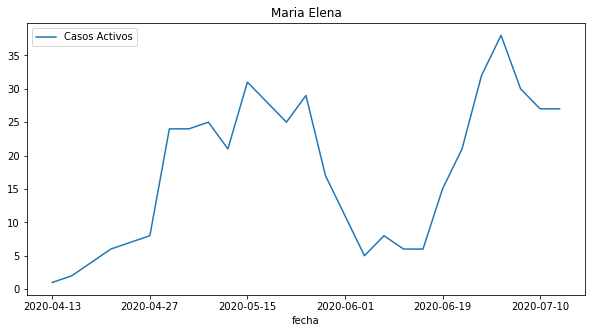

In [18]:
Comuna = np.random.choice(comunas, 1, replace=False)[0]
sample = unpivoted[unpivoted['Comuna'] == Comuna]
sample.plot(x='fecha', y='Casos Activos', title=Comuna, figsize=(10,5))

In [56]:
df_geo = gp.read_file('Geo info/comunas.shp')
#rmdf = df_geo[df_geo.NOM_PROV=='Santiago'].copy()
rmdf = df_geo.copy()
rmdf['NOM_COM'] = rmdf['NOM_COM'].apply(lambda x: elimina_tildes(x))
rmdf = rmdf.merge(df_id_comunas, left_on='NOM_COM', right_on='Comuna_Clean')
print('Procesamos %d comunas de Chile' %len(rmdf))

Procesamos 344 comunas de Chile


In [57]:
rmdf.head(5)

,NOM_COM,REGION,PROV,CODIGO,geometry,Comuna_Clean,Codigo comuna
0,Ercilla,Región de La Araucanía,Malleco,9204,"POLYGON ((-72.52316 -37.94412, -72.52224 -37.9...",Ercilla,9204
1,Lonquimay,Región de La Araucanía,Malleco,9205,"POLYGON ((-71.34596 -38.08866, -71.34527 -38.0...",Lonquimay,9205
2,Los_Sauces,Región de La Araucanía,Malleco,9206,"POLYGON ((-72.91459 -37.83951, -72.91432 -37.8...",Los_Sauces,9206
3,Lumaco,Región de La Araucanía,Malleco,9207,"POLYGON ((-72.88079 -38.07505, -72.87878 -38.0...",Lumaco,9207
4,Puren,Región de La Araucanía,Malleco,9208,"POLYGON ((-73.03074 -37.84025, -73.02991 -37.8...",Puren,9208


In [58]:
geo_comunas_json = list(rmdf['NOM_COM'].unique())
geo_comunas_min = list(df_metro['Comuna_Clean'].unique())

In [59]:
excluidas = []
for c in geo_comunas_min:
    if c not in geo_comunas_json:
        excluidas.append(c)
excluidas

['Desconocido_Arica_y_Parinacota',
 'Total',
 'Desconocido_Tarapaca',
 'Desconocido_Antofagasta',
 'Desconocido_Atacama',
 'Desconocido_Coquimbo',
 'Desconocido_Valparaiso',
 'Desconocido_Metropolitana',
 'Desconocido_O’Higgins',
 'Desconocido_Maule',
 'Desconocido_Nuble',
 'Desconocido_Biobio',
 'Desconocido_Araucania',
 'Desconocido_Los_Rios',
 'Desconocido_Los_Lagos',
 'OHiggins',
 'Desconocido_Aysen',
 'Antartica',
 'Desconocido_Magallanes']

In [60]:
matching = [s for s in geo_comunas_min if "Higg" in s]
matching

['Desconocido_O’Higgins', 'OHiggins']

In [61]:
matching2 = [s for s in geo_comunas_json if "huano" in s]
matching2

['Talcahuano']

In [62]:
unpivoted['filtro'] = unpivoted['Comuna_Clean'].apply(lambda x: x not in excluidas)
final = unpivoted[unpivoted['filtro'] == True].copy()
final.drop(columns={'filtro'}, inplace=True)
final['Codigo comuna'] = final['Codigo comuna'].astype(int)

In [63]:
len(final.Comuna.unique())

344

In [64]:
final['CA cada 1000'] = (final['Casos Activos'] / final['Poblacion'])*1000
final.head()

,Comuna,Comuna_Clean,Codigo comuna,Poblacion,Region,fecha,Casos Activos,CA cada 1000
0,Arica,Arica,15101,247552.0,Arica y Parinacota,2020-04-13,88.0,0.355481
1,Camarones,Camarones,15102,1233.0,Arica y Parinacota,2020-04-13,0.0,0.000000
2,General Lagos,General_Lagos,15202,810.0,Arica y Parinacota,2020-04-13,0.0,0.000000
3,Putre,Putre,15201,2515.0,Arica y Parinacota,2020-04-13,0.0,0.000000
6,Alto Hospicio,Alto_Hospicio,1107,129999.0,Tarapaca,2020-04-13,8.0,0.061539


In [65]:
def get_hex_colors(value, cats):
    '''
    Color paletter used from this website:
    
    https://colorbrewer2.org/#type=sequential&scheme=Reds&n=9
    
    The color selection will be based on the percentile each value is in.
    '''
    base = Color("yellow")
    final = Color("red")
    n = len(cats)
    colors = list(base.range_to(final,n))
    r = range(0, n-1)
    
    for i in r:
        if value in cats[i]:
            return colors[i].hex
    return colors[n-1].hex

In [66]:
def get_transparency(value, cats):
    n = len(cats)
    inicio = 0.4
    final = 0.9
    asdf = np.arange(inicio, final, (final - inicio)/n)
    r = range(0, n-1)
    
    for i in r:
        if value in cats[i]:
            return asdf[i]
    return asdf[n-1]

In [67]:
final['fecha']=pd.to_datetime(final['fecha']).apply(lambda x: x - pd.DateOffset(days=1))
final.dtypes

Comuna                   object
Comuna_Clean             object
Codigo comuna             int32
Poblacion               float64
Region                   object
fecha            datetime64[ns]
Casos Activos           float64
CA cada 1000            float64
dtype: object

In [68]:
final['Date_for_Folium']=((final['fecha'].astype(np.int64) // 10**9)+24*60*60*2).astype('U10')
final.head()

,Comuna,Comuna_Clean,Codigo comuna,Poblacion,Region,fecha,Casos Activos,CA cada 1000,Date_for_Folium
0,Arica,Arica,15101,247552.0,Arica y Parinacota,2020-04-12,88.0,0.355481,1586822400
1,Camarones,Camarones,15102,1233.0,Arica y Parinacota,2020-04-12,0.0,0.000000,1586822400
2,General Lagos,General_Lagos,15202,810.0,Arica y Parinacota,2020-04-12,0.0,0.000000,1586822400
3,Putre,Putre,15201,2515.0,Arica y Parinacota,2020-04-12,0.0,0.000000,1586822400
6,Alto Hospicio,Alto_Hospicio,1107,129999.0,Tarapaca,2020-04-12,8.0,0.061539,1586822400


In [69]:
#----------------------------------------------------------------------------------
data_to_color = "CA cada 1000"
cantidad_cuartiles = 15
cats, bins =  pd.qcut(final[data_to_color].unique()[np.argsort(final[data_to_color].unique())], q = cantidad_cuartiles, retbins = True)
cats = cats.unique()

#----------------------------------------------------------------------------------

# value we will iterate in order to create the styledict
ccaas = list(final["Codigo comuna"].unique())
dates = list(final["Date_for_Folium"].unique())

#create the color dict and color column
final["COLORS"] = final[data_to_color].apply(get_hex_colors, args = [cats])
final["OPACITY"] = final[data_to_color].apply(get_transparency, args = [cats])

#colors = get_hex_colors(final, data_to_color, cmap = matplotlib.cm.Reds, log=True)
#final["COLORS"] = final[data_to_color].map(colors)

In [70]:
final.head()

,Comuna,Comuna_Clean,Codigo comuna,Poblacion,Region,fecha,Casos Activos,CA cada 1000,Date_for_Folium,COLORS,OPACITY
0,Arica,Arica,15101,247552.0,Arica y Parinacota,2020-04-12,88.0,0.355481,1586822400,#ffa400,0.566667
1,Camarones,Camarones,15102,1233.0,Arica y Parinacota,2020-04-12,0.0,0.000000,1586822400,#ff0,0.400000
2,General Lagos,General_Lagos,15202,810.0,Arica y Parinacota,2020-04-12,0.0,0.000000,1586822400,#ff0,0.400000
3,Putre,Putre,15201,2515.0,Arica y Parinacota,2020-04-12,0.0,0.000000,1586822400,#ff0,0.400000
6,Alto Hospicio,Alto_Hospicio,1107,129999.0,Tarapaca,2020-04-12,8.0,0.061539,1586822400,#ff0,0.400000


In [71]:
# creates the styledict for the map
styledict = {}

# iterate the populate the styledict
for ccaa in ccaas:
    styledict[str(ccaa)] = {date: {'color': final[(final["Codigo comuna"] == ccaa) & (final["Date_for_Folium"] == date)]["COLORS"].values[0],
                                   'opacity': final[(final["Codigo comuna"] == ccaa) & (final["Date_for_Folium"] == date)]["OPACITY"].values[0]} for date in dates}

In [72]:
this = rmdf.set_index('Codigo comuna')

In [73]:
color_base = Color("yellow")
color_final = Color("red")
n = len(cats)
the_colors = list(color_base.range_to(color_final,n))
rango = range(0, n-1)

In [74]:
import branca.colormap as cm

m = folium.Map(location=(-33.38187075, -70.53537879464088), tiles='Stamen Toner', zoom_start=10)

g = TimeSliderChoropleth(
    this, # get's the coordinates for each id 
    styledict = styledict # styledict contains for each id the timestamp and the color to plot.
)

m.add_child(g)

#--------------------------------------------------------------------------------------
# Let's create a legend for folium
# https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd

from branca.element import Template, MacroElement

parte1 = """     
    <li><span style='background:
    """
parte2 = """     
    ;opacity:0.6;'></span>
    """
parte3 ="""
    </li>
    
    """

asdf2 = ""

for r in rango:
    descripcion = str(cats[r])
    asdf2 = asdf2 + parte1 + the_colors[r].hex + parte2 + descripcion + parte3


a = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Casos Actvos cada 1000 personas</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
"""

b = """
  <li>por Camilo Fuentes M.</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

template = a + asdf2 + b

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

html_location = './docs/Casos Activos COVID19 cada 1000 habitantes por Comunda de Chile.html' 

m.save(html_location)


D:\Anaconda\envs\Geopanda_Env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [75]:
from IPython.display import IFrame

IFrame(src=html_location, width=1300, height=600)